First we import tensorflow, numpy and matplotlib.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

The next cell defines a function to load in the MNIST csv files I downloaded and zipped (you gotta unzip them yourself), and then loads the data. This takes a minute because the method I am using to load data is slow.

In [2]:
def load(f):
    F = open(f,"r")
    out = []
    label = []
    for l in F:
        temp = [int(t) for t in l.split(",")]
        out.append(temp[1:])
        label.append(temp[0])
        
    return np.array(out),np.array(label)

train_data,train_label = load("./mnist_train.csv")
test_data,test_label = load("./mnist_test.csv")

Visualize a digit, becasue it's always good to look at your data!

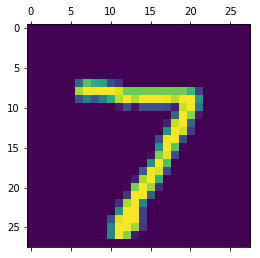

In [3]:
plt.matshow(np.reshape(test_data[0],[28,28]))
plt.show()

Set hyperparameters

In [4]:
batch_size = 16
data_size = len(test_data[0])
learning_rate = .001
n_epochs = 10000
n_labels = 10

Normalize the data. Note that we retain `m` and `s` so that we can normalize the test data in exactly the same way!

In [5]:
m = np.mean(train_data)
s = np.std(train_data)

normed_data = (train_data - m)/s

These placeholders represent the inputs and labels for the data, which we will fill in later.

In [6]:
tf.reset_default_graph()

input_data = tf.placeholder(tf.float32,shape = (None,data_size))
labels = tf.placeholder(tf.float32,shape = (None,10))

This defines the neural network layer by layer. Note that the last layer uses a linear activation function to generate *unnormalized log probabilities*. This is beause the loss function I used assumes the inputs are as such, and applies a softmax internally.

In [7]:
layer1 = tf.layers.dense(input_data,256,activation = tf.nn.relu,name = "L1")
layer2 = tf.layers.dense(layer1,256,activation = tf.nn.relu,name = "L2")
layer3 = tf.layers.dense(layer2,256,activation = tf.nn.relu,name = "L3")

logits = tf.layers.dense(layer3,n_labels,activation = None)

Define the loss: average cross entropy loss between the NN output and the 1-hot encoded labels. Also create an ADAM optimizer and generate the training operation `train`.

The variable `scope` controls the parameters that are trained. If `scope = None` then all parameters are trained. by making the `scope` equal to a lyaer name (see above) you restrict training to only those variables. Play with this! In particular, the network learns much better if only `L1` weights are trained than if only `L3` weights are trained! Why?

In [8]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels = labels, logits = logits))

scope = ""

regularize = .0001*tf.reduce_sum([tf.reduce_sum(t**2) for t in tf.trainable_variables(scope = scope)])

adam = tf.train.AdamOptimizer(learning_rate = learning_rate)

train = adam.minimize(loss + regularize,var_list = tf.trainable_variables(scope = scope))


These helper functions take in a set of labels and generates a 1-hot encoding of them (`make_1hot`) and calculate the error based on the MAP estimate of the label (`MNIST_err`).

In [9]:
def make_1hot(l):
    out = np.zeros(shape = (len(l),n_labels))
    for k in range(len(l)):
        out[k][l[k]] = 1
        
    return out

def MNIST_err(l,p):
    out = []
    for k in range(len(l)):
        if l[k][np.argmax(p[k])] == 1:
            out.append(1)
        else:
            out.append(0)
            
    return np.mean(out)

Create a session (on CPU) and initialize all the TF variables. That is, the weights and biases of the network, and the adam momentum variables. 

In [10]:
init = tf.global_variables_initializer()
config = tf.ConfigProto(device_count = {'GPU': 0})
sess = tf.Session(config=config)
sess.run(init)

Run the training loop! 

At each step, pick a random batch of training data, run the training operation substituting in the batch of data for the placeholders above. 

Also periodically run the test data and record the train and test data.

In [11]:
results = []
print_freq = 500
test_freq = 10
normed_test = (test_data - m)/s
test_label_1h = make_1hot(test_label)

for k in range(n_epochs):
    b_index = np.random.choice(range(len(test_data)),batch_size,replace = False)
    batch_data = normed_data[b_index]
    batch_labels = make_1hot(train_label[b_index])
    
    _,train_loss,train_logits = sess.run([train,loss,logits],{input_data:batch_data,labels:batch_labels})
    
    if k%test_freq == 0:
        test_loss,test_logits = sess.run([loss,logits],{input_data:normed_test,labels:test_label_1h})
        results.append([k,MNIST_err(test_label_1h,test_logits),MNIST_err(batch_labels,train_logits)])
    if k%print_freq == 0:
        print("{}\t{}\t{}".format(k,train_loss,test_loss))
        
results = np.array(results)

0	2.6044178009033203	2.2890465259552
500	0.31586727499961853	0.2623869478702545
1000	0.020617838948965073	0.2751045525074005
1500	0.014306576922535896	0.23576240241527557
2000	0.27641505002975464	0.28240007162094116
2500	0.13238491117954254	0.26960381865501404
3000	0.26430851221084595	0.1924436241388321
3500	0.0130679402500391	0.258617639541626
4000	0.030208410695195198	0.22844243049621582
4500	0.0023681584279984236	0.2158425748348236
5000	0.04970547556877136	0.1994590312242508
5500	0.01737111061811447	0.30292144417762756
6000	6.191886495798826e-05	0.18442440032958984
6500	0.0234233308583498	0.25924351811408997
7000	0.2882676422595978	0.17735989391803741
7500	0.004632960073649883	0.22748690843582153
8000	0.00020704278722405434	0.19489534199237823
8500	0.007452618330717087	0.1940983384847641
9000	0.16338008642196655	0.1959521770477295
9500	2.542755646572914e-05	0.18490654230117798


In [12]:
sess.close()

Finally, visualize the results of training.

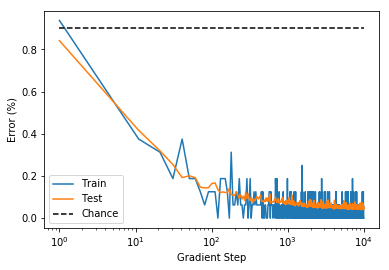

In [13]:
plt.plot(1+results[:,0],1-results[:,2],label = "Train")
plt.plot(1+results[:,0],1-results[:,1],label = "Test")
plt.plot(1+results[:,0],np.ones_like(results[:,1])*.9,"k--",label = "Chance")
plt.legend()
plt.xlabel("Gradient Step")
plt.ylabel("Error (%)")
plt.xscale("log")
plt.show()

Things for YOU to play with:

    - Adjust learning rate, number/size of hidden layers, loss function (what about rms error?).
    - Add drop out between dense layers.
    - Augment the dataset: flip horizontally/vertically. Affine transformations. Add Noise.
    - Try other activation functions.
    - Try making the network convolutional.
    - Restrict the parameters that are trained.